In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
import matplotlib.animation as animation

### The Model

$$ R\frac{\partial T}{\partial t} = Qs(y)(1-\alpha(y))-(A+BT)+C(\bar{T}-T) $$

#### Equillibrium Temperature - Constant Albedo

<h5> What is Albedo? </h5>
<p> the measure of the diffuse reflection of solar radiation out of the total solar radiation and measured on a scale from 0, corresponding to a black body that absorbs all incident radiation, to 1, corresponding to a body that reflects all incident radiation </p>
<p> https://en.wikipedia.org/wiki/Albedo </p>

#### alpha_hat calculation

<h5> With the Chylek and Coakley's quadratic approximation </h5>

$$ s(y) \approx 1-0.241(3y^2-1) $$

$$\bar{\alpha} = \int_0^1 \alpha s(y)dy = \alpha \int_0^1 1-0.241(3y^2-1) dy$$
$$ = \alpha \int_0^1 1 dy - 0.241*3\alpha\int_0^1 y^2 dy + \alpha\int_0^1 0.241 dy $$
$$ \alpha - 0.241\alpha + 0.241\alpha = \alpha $$ 

In [5]:
def s(y):
    return 1 - 0.241*(3*np.square(y)-1)
def T_hat_star(B, alpha_hat, A, Q):
    return (1/B)*(Q*(1-alpha_hat)-A)
#generate the equillibrium profile based on parameters
def Gen_Equil_Temp_Prof(B,C,Q,s,alpha,A,T_hat_star):
    def equil_temp_prof(y):
        return ((1/(B+C))*(Q*s(y)*(1-alpha)-A+C*
            T_hat_star(B, alpha, A, Q)))
    return equil_temp_prof 
def alpha_function(y, eta, a_1, a_2):
    mask = y > eta
    y_new = np.copy(y)
    y_new[mask] = a_1
    y_new[~mask] = a_2
    return y_new
def alpha_hat(eta, a_1, a_2):
    return a_1 - (a_1-a_2)*(eta-0.241*(eta**3-eta))
def T_Hat_Star(A,B,Q,eta,a_1,a_2):
    return 1/B*(Q*(1-alpha_hat(eta, a_1, a_2))-A)
def T_eta_star(B,C,Q,A,y,a_1,a_2,eta):
    return 1/(B+C)*(Q*s(y)*(1-alpha_function(y,eta,a_1,a_2))-A
                +C*T_Hat_Star(A,B,Q,eta,a_1,a_2))

#### Equilibrium Temperature Profiles

<Figure size 432x288 with 0 Axes>

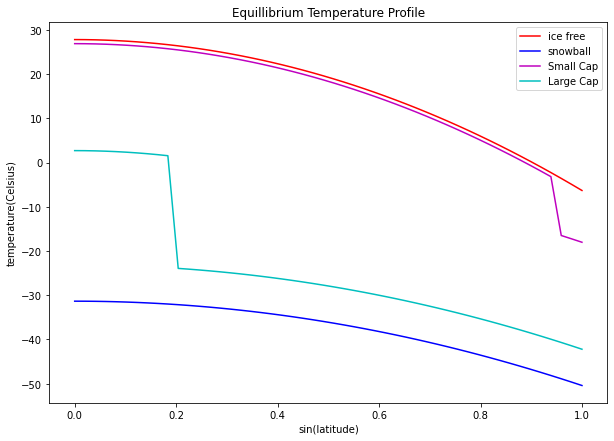

In [5]:
#define the constants
eta_1 = 0.95
eta_2 = 0.2
a_1 = 0.62
a_2 = 0.32
A = 202
B = 1.9
C = 1.6*B
Q = 343
y = np.linspace(0,1,50,endpoint=True)
#plot the equillibrium temperature
plt.clf()
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(y,Gen_Equil_Temp_Prof(B,C,Q,s,0.32,A,T_hat_star)(y),color='r', label='ice free')
ax.plot(y,Gen_Equil_Temp_Prof(B,C,Q,s,0.62,A,T_hat_star)(y),color='b',label='snowball')
ax.plot(y,T_eta_star(B,C,Q,A,y,a_1,a_2,eta_1),color='m', label='Small Cap')
ax.plot(y,T_eta_star(B,C,Q,A,y,a_1,a_2,eta_2),color='c', label='Large Cap')
ax.set_title("Equillibrium Temperature Profile")
ax.set_xlabel('sin(latitude)')
ax.set_ylabel('temperature(Celsius)')
plt.legend()
plt.show()

#### We are assuming symmetry. This means both semispheres (above the equator and below the equator) have symmetrical temperature patters, so the above graph really only represents the equllibrium temperature profile of one of the semispheres, but we are assuming it represents both.

<p> We have the equllibrium equation </p>
$$ T_n^*(y) = \frac{1}{B+C}(Qs(y)(1-\alpha(y,\eta))-A+C\bar{T}_{\eta}^*) $$
<p> And the critical equation </p>
$$ T_c = \frac{1}{2}(T_\eta^*(\eta+)+T_\eta^*(\eta-)) $$

<h5> We impose the condition $T_c = 0$ and then we get an ice line condtion equation that must be satisfied </h5> 
$$ h(\eta) = \frac{1}{B+C}(Qs(\eta)(1-a_0)-A+C\bar{T}_n^*)-T_c $$
$$ = \frac{Q}{B+C}(s(\eta)(1-a_0)+\frac{C}{B}(1-a_2+(a_2-a_1)S(\eta)))-\frac{A}{B} - T_c = 0 $$

In [6]:
def s(y):
    return 1-0.241*(3*np.square(y)-1)
def S(eta):
    return eta-0.241*(np.power(eta,3)-eta) 
def h(Q,A,B,C,T_c,eta,a_0,a_1,a_2):
    return Q/(B+C)*(s(eta)*(1-a_0)+C/B*(1-a_1+(a_1-a_2)*S(eta)))-A/B-T_c

#### Plot $h(\eta)$ to solve the satisfying values 

<Figure size 432x288 with 0 Axes>

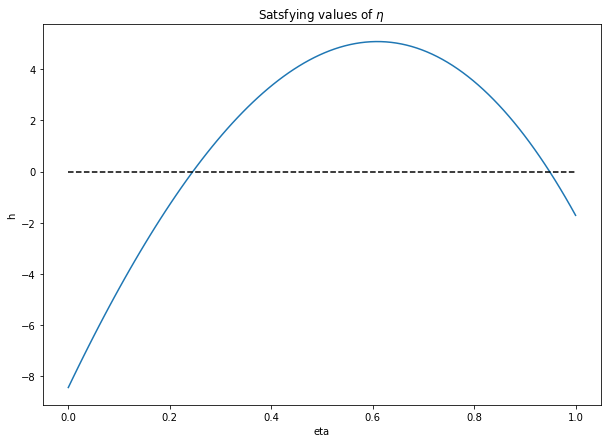

In [7]:
#set the vals
eta_vals = np.linspace(0,1,100)
a_1 = 0.62
a_2 = 0.32
a_0 = (a_1+a_2)/2
A = 202
B = 1.9
C = 1.6*B
Q = 343
T_c = -10
vals = h(Q,A,B,C,T_c,eta_vals,a_0,a_1,a_2)
plt.clf()
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(eta_vals, vals)
ax.plot(eta_vals, np.zeros_like(eta_vals), linestyle='dashed', color='k')
ax.set_xlabel('eta')
ax.set_ylabel('h')
ax.set_title("Satsfying values of $\eta$")
plt.show()

### Budyko-Sellers Model

$$\frac{d\eta}{dt}  = \epsilon(T(\eta) - T_c) $$
$$ \frac{dT}{dt} = \frac{1}{R} \left(Qs(y)(1-\alpha(y))-(A+BT)+C(\bar{T}-T)\right) $$

In [107]:
def get_T0_from_current_data(year=2020):
    """Call this function to use current data to use as initial budyko model points
       As of right now this data does not seem to have a good delta y value for model
       success
    """
    temp_data = pd.read_csv(str(year)+'_mean_temp.csv', index_col=0)
    T_init = temp_data[str(year)]
    #fill the nan values with the average of nearest neighbors
    T_init = T_init.fillna(method='ffill') + T_init.fillna(method='bfill')/2
    #convert to numpy arrays
    T_init = np.array(T_init)
    #now get the eta value
    T_diff = np.absolute(T_init[1:] - T_init[:-1])
    max_arg = np.argmax(T_diff)
    y_vals = temp_data.index.to_numpy()
    eta = (y_vals[max_arg] + y_vals[max_arg+1])/2
    return T_init, y_vals, eta

In [3]:
class BudykoSellers:
    """Class for solving and animating the above model over a specified time period
    """
    def __init__(self, T_0, y, epsilon = 0.01, eta_0 = 0.5, a_1 = 0.62, 
       a_2 = 0.32, A = 202, B = 1.9, C = 3.04, Q = 343, R = 12.6, T_c = -10):
        #define class variables
        self.y = y
        self.eta_0 = eta_0
        self.a_1 = a_1
        self.a_2 = a_2
        self.s_y = self.s()
        self.R = R
        self.Q = Q
        self.A = A
        self.B = B
        self.C = C
        self.epsilon = epsilon
        self.T_c = T_c
        self.computed=False
        #now create T_init
        self.T_0 = T_0.tolist()
        self.T_0.append(self.eta_0)
        self.T_0 = np.array(self.T_0)
    def s(self):
        return 1 - 0.241*(3*np.square(self.y)-1)
    def alpha_function(self, eta):
        mask = self.y > eta
        y_new = np.copy(self.y)
        y_new[mask] = self.a_1
        y_new[~mask] = self.a_2
        return y_new
    def compute_global_mean(self, T):
        return np.mean(T)
    def get_T_eta(self, eta):
        #get arguments to be used in approximate calculate of T(eta)
        sorted_args = np.argsort(np.absolute(self.y-eta))
        arg_1 = sorted_args[0]
        arg_2 = sorted_args[1]
        return arg_1, arg_2
    def update_T(self, T_vals, eta):
        #how to update the temperature function
        return 1/self.R*(self.Q*self.s_y*(1-self.alpha_function(eta)) 
            -(self.A+self.B*T_vals)+self.C*(self.compute_global_mean(T_vals) - T_vals))
    def update(self, T, y):
        #update function for ivp solver
        T_vals = y[:-1]
        eta = y[-1]
        new_T = self.update_T(T_vals, eta)
        arg_1, arg_2 = self.get_T_eta(eta)
        T_eta_arg = (T_vals[arg_1] + T_vals[arg_2])/2
        eta_update = self.epsilon*(T_eta_arg - self.T_c)
        return_list = [T_val for T_val in new_T]
        return_list.append(eta_update)
        return return_list
    def get_solution(self, t):
        max_t = t[-1]
        min_t = t[0]
        #now use the scipy solver
        solution = solve_ivp(self.update, t_span=[min_t,max_t], y0 = self.T_0, t_eval=t)
        #solution
        self.solution = solution['y']
        self.time_series = solution['t']
        self.computed=True
    def save_animation(self, filepath_name=None):
        if (self.computed is False):
            raise NotImplmentedError("Have not yet computed solution, call self.solution() with parameter t")
        plt.ioff()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        traj, = ax.plot([],[], color='b', alpha=0.9, label='Temperature Profile')
        eta, = ax.plot([],[],color='r', marker='o', alpha=0.9, label='Eta')
        ax.set_xlabel("sin(latitude)")
        ax.set_xlim([0,1])
        ax.set_ylim([-50,50])
        ax.set_ylabel("Temperature")
        plt.legend()
        ax.set_title("Budyko-Sellers Model (eta_0={})".format(self.eta_0))
        def mation(i):
            traj.set_data(self.y, self.solution[:-1,i])
            arg_1, arg_2 = self.get_T_eta(self.solution[-1,i])
            T_eta = (self.solution[:-1, i][arg_1]+self.solution[:-1, i][arg_2])/2
            eta.set_data(self.solution[-1,i],T_eta)
            return traj,eta
        #create the animation
        if filepath_name is None:
            filepath_name = '../Data/BudykoSellersAnimation/budyko-eta0_{}-epsilon_{}.mp4'.format(self.eta_0,self.epsilon)
        ani = animation.FuncAnimation(fig, mation, frames=range(self.time_series.shape[0]), interval=5)
        #save the animation
        ani.save(filepath_name)
        print("Saved to {}".format(filepath_name))
        plt.close(fig)

In [4]:
def run_params_test():
    """Function gives an example on how to use class above and also recreates animations 
    for various hyperparameters (they are already on the github though)"""
    #run animation with various parameters
    def init_T(y):
        return 14-54*np.square(y)
    y_vals = np.linspace(0,1,500)
    #T_init with a design function (not the actual values)
    T_init = init_T(y_vals)
    #time values to animate and solve on
    t = np.linspace(1,2500,2500,endpoint = True, dtype=int)
    #define list of test parameters
    test_params = [(0.5,0.01),(0.5,0.0),(0.1,0.01),(0.1,0.0),(1,0.01),(1,0.0)]
    for eta_0, epsilon in test_params:
        #create model and get and save solution
        budyko_model = BudykoSellers(T_init, y_vals, eta_0=eta_0, epsilon=epsilon)
        budyko_model.get_solution(t)
        budyko_model.save_animation()

### Budyko Sellers Widiasih with $\beta$ modification

$$\frac{d\eta}{dt}  = \epsilon(T(\eta) - T_c) $$
$$\frac{dT}{dt} = \frac{1}{R} \left(Qs(y)(1-\alpha(y))-(A+BT)+C(\bar{T}-T)\right) $$
$$\frac{dA}{dt} =   \hat{\epsilon}(\eta - \eta_c) - \beta(t) $$

In [2]:
class ModifiedBudykoSellers:
    """Class created to implement the above specified model with varying parameters. Each function/method/parameter
       In the class is defined in a self_explanatory and helpful way
    
    """
    def __init__(self, T_init, y, beta, beta_0 = 0.01, epsilon = 0.01, epsilon_hat = 0.001, eta_0 = 0.5,
            a_1 = 0.62, a_2 = 0.32, eta_c = 0.2, A_0 = 202, B = 1.9, C = 3.04, Q = 343, 
            R = 12.6, T_c = -10):
        self.y = y
        self.eta_0 = eta_0
        self.a_1 = a_1
        self.a_2 = a_2
        self.R = R
        self.Q = Q
        self.A_0 = A_0
        self.B = B
        self.C = C
        self.epsilon = epsilon
        self.epsilon_hat = epsilon_hat
        self.eta_c = eta_c
        self.T_c = T_c
        self.s_y = self.s()
        self.beta = beta
        #compute the initial value to the problem
        T_init = T_init.tolist()
        T_init.append(eta_0)
        T_init.append(A_0)
        self.T_0 = np.array(T_init)
        self.computed=False
        self.beta_0 = beta_0
    def s(self):
        return 1 - 0.241*(3*np.square(self.y)-1)
    def alpha_function(self, eta):
        mask = self.y > eta
        y_new = np.copy(self.y)
        y_new[mask] = self.a_1
        y_new[~mask] = self.a_2
        return y_new
    def compute_global_mean(self, T):
        return np.mean(T)
    def get_T_eta(self, eta):
        #get the arguments to get T(eta) value
        sorted_args = np.argsort(np.absolute(self.y-eta))
        arg_1 = sorted_args[0]
        arg_2 = sorted_args[1]
        return arg_1, arg_2
    def update_eta(self, T_vals, eta):
        #the eta update function
        arg_1, arg_2 = self.get_T_eta(eta)
        T_eta_arg = (T_vals[arg_1] + T_vals[arg_2])/2
        update_val = self.epsilon*(T_eta_arg - self.T_c)
        if (eta+update_val > 1):
            return 0
        if (eta+update_val < 0):
            return 0
        return update_val
    def update_T(self, T_vals, eta, A):
        #what to update T with
        return 1/self.R*(self.Q*self.s_y*(1-self.alpha_function(eta)) - (A+self.B*T_vals)
         + self.C*(self.compute_global_mean(T_vals) - T_vals))
    def update(self,t,y):
        #update function for ivp solver
        T_vals = y[:-2]
        eta = y[-2]
        A = y[-1]
        new_T = self.update_T(T_vals, eta, A)
        eta_update = self.update_eta(T_vals, eta)
        beta_val = self.beta(t)
        A_update = self.epsilon_hat*(eta - self.eta_c) - beta_val
        return_list = [T_val for T_val in new_T]
        return_list.append(eta_update)
        return_list.append(A_update)
        return return_list
    def get_solution(self, t):
        max_t = t[-1]
        min_t = t[0]
        #now use the scipy solver
        solution = solve_ivp(self.update, t_span=[min_t,max_t], y0 = self.T_0, t_eval=t)
        #solution
        self.solution = solution['y']
        self.time_series = solution['t']
        self.computed=True
    def save_animation(self, filepath_name=None):     
        #animate the temperature solution
        plt.ioff()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        traj, = ax.plot([],[], color='b', alpha=0.9, label='Temperature Profile')
        eta, = ax.plot([],[],color='r', marker='o', alpha=0.9, label='Eta')
        ax.set_xlabel("sin(latitude)")
        ax.set_xlim([-0.1,1.1])
        ax.set_ylim([-50,50])
        ax.set_ylabel("Temperature")
        plt.legend()
        ax.set_title("Budyko-Sellers-Modified Model (eta_0={})".format(self.eta_0))
        def mation(i):
            traj.set_data(self.y, self.solution[:-2,i])
            arg_1, arg_2 = self.get_T_eta(self.solution[-2,i])
            T_eta = (self.solution[:-2, i][arg_1] + self.solution[:-2, i][arg_2])/2
            eta.set_data(self.solution[-2,i],T_eta)
            return traj,eta
        #create the animation
        if filepath_name is None:
            filepath_name = '../Data/BudykoSellersModifiedAnimation/budyko-sellers-m-epsilon_hat_{}_eta0_{}-eta_c_{}-A0_{}.mp4'.format(self.epsilon_hat, self.eta_0,self.eta_c,self.A_0)
        ani = animation.FuncAnimation(fig, mation, frames=range(self.time_series.shape[0]), interval=5)
        #save the animation
        ani.save(filepath_name)
        print("Saved to {}".format(filepath_name))
        plt.close(fig)

### beta = 0 - the original Widiasakih estimation

In [7]:
def init_T(y):
    return 14-54*np.square(y)
y_vals = np.linspace(0,1,500)
#T_init with a design function (not the actual values)
T_init = init_T(y_vals)
eta_0 = 0.75

In [8]:
def beta(t):
    return 0
#time values
t = np.linspace(1,2500,2500,endpoint = True, dtype=int)
#now use the model
budyko_modified_zero = ModifiedBudykoSellers(T_init, y_vals, beta, beta_0=0, eta_0=eta_0)
budyko_modified_zero.get_solution(t)

In [9]:
#animate the model
#now save the animation
budyko_modified_zero.save_animation(filepath_name = 
    '../Data/BudykoSellersModifiedAnimation/zero_beta.mp4')

Saved to BudykoSellersModifiedAnimation/zero_beta.mp4


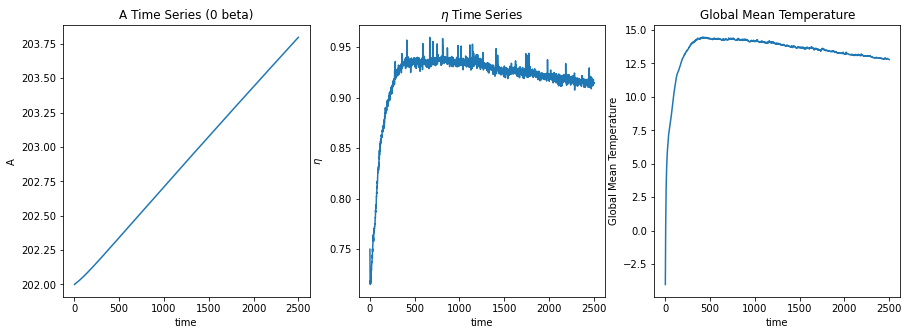

In [10]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
T_vals = budyko_modified_zero.solution[:-2,:]
T_mean = np.mean(T_vals, axis=0)
ax[0].plot(t,budyko_modified_zero.solution[-1],label="A Time Series")
ax[0].set_xlabel("time")
ax[0].set_ylabel("A")
ax[0].set_title("A Time Series (0 beta)")
ax[1].plot(t,budyko_modified_zero.solution[-2], label="Eta time series")
ax[1].set_xlabel("time")
ax[1].set_ylabel("$\eta$")
ax[1].set_title("$\eta$ Time Series")
ax[2].plot(t, T_mean)
ax[2].set_xlabel("time")
ax[2].set_ylabel("Global Mean Temperature")
ax[2].set_title("Global Mean Temperature")
plt.show()

### Positive beta - corresponding to increasing carbon emissions

In [11]:
def init_T(y):
    return 14-54*np.square(y)
y_vals = np.linspace(0,1,500)
#T_init with a design function (not the actual values)
T_init = init_T(y_vals)
eta_0 = 0.75

In [12]:
def beta(t):
    return 0.01
#time values
t = np.linspace(1,2500,2500,endpoint = True, dtype=int)
#now use the model
budyko_modified = ModifiedBudykoSellers(T_init, y_vals, beta, beta_0=0.01, eta_0=eta_0)
budyko_modified.get_solution(t)

In [13]:
#animate the model
#now save the animation
budyko_modified.save_animation(filepath_name = 
    '../Data/BudykoSellersModifiedAnimation/positive_beta.mp4')

Saved to BudykoSellersModifiedAnimation/positive_beta.mp4


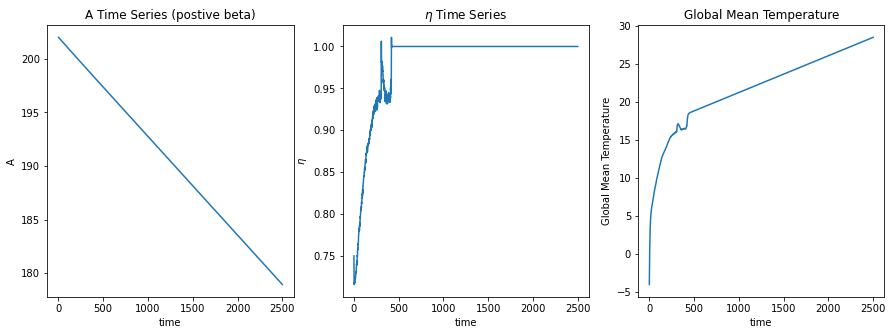

In [14]:
#analyze results
#plot A changes and eta changes over time
T_vals = budyko_modified.solution[:-2,:]
T_mean = np.mean(T_vals, axis=0)
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(t,budyko_modified.solution[-1],label="A Time Series")
ax[0].set_xlabel("time")
ax[0].set_ylabel("A")
ax[0].set_title("A Time Series (postive beta)")
ax[1].plot(t,budyko_modified.solution[-2], label="Eta time series")
ax[1].set_xlabel("time")
ax[1].set_ylabel("$\eta$")
ax[1].set_title("$\eta$ Time Series")
ax[2].plot(t, T_mean)
ax[2].set_xlabel("time")
ax[2].set_ylabel("Global Mean Temperature")
ax[2].set_title("Global Mean Temperature")
plt.show()

### Cyclical-Type Beta - cycling positive and negative carbon emissions

In [3]:
def init_T(y):
    return 14-54*np.square(y)
y_vals = np.linspace(0,1,500)
#T_init with a design function (not the actual values)
T_init = init_T(y_vals)
eta_0 = 0.75

<Figure size 432x288 with 0 Axes>

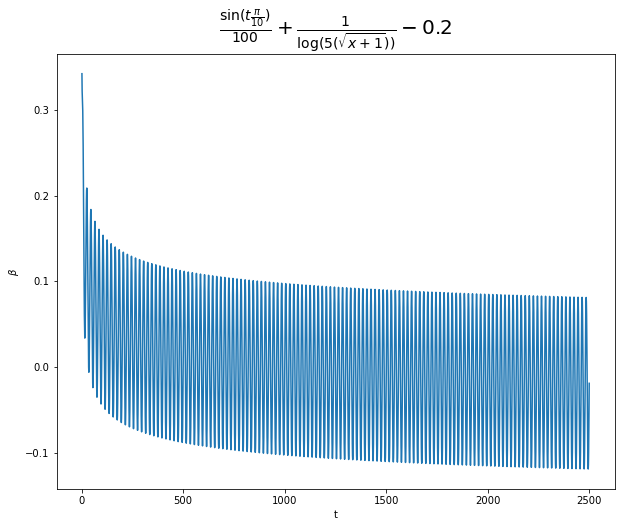

In [4]:
def beta(t_val):
    return np.sin(t_val*np.pi/10)/10 + 1/np.log(5*np.sqrt(t_val+1))-0.2
#now use the model
#time values
t = np.linspace(1,2500,2500,endpoint = True, dtype=int)
budyko_modified_cyclical = ModifiedBudykoSellers(T_init, y_vals, beta, beta_0=0.01, eta_0=eta_0)
budyko_modified_cyclical.get_solution(t)
#plot the beta function
plt.clf()
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(t, beta(t))
ax.set_title(r"$\frac{\sin(t \frac{\pi}{10})}{100}+\frac{1}{\log(5(\sqrt{x+1}))}-0.2$")
ax.title.set_fontsize(20)
ax.set_xlabel("t")
ax.set_ylabel(r"$\beta$")
plt.show()

In [17]:
#now save the animation
budyko_modified_cyclical.save_animation(filepath_name = 
    'BudykoSellersModifiedAnimation/cyclical_beta.mp4')

Saved to BudykoSellersModifiedAnimation/cyclical_beta.mp4


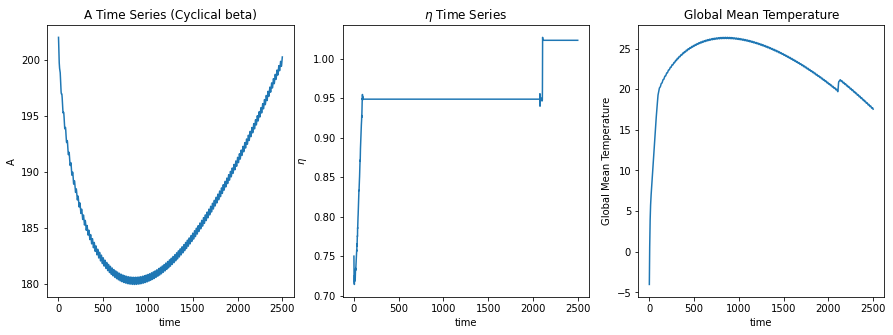

In [18]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
T_vals = budyko_modified_cyclical.solution[:-2,:]
T_mean = np.mean(T_vals, axis=0)
ax[0].plot(t,budyko_modified_cyclical.solution[-1],label="A Time Series")
ax[0].set_xlabel("time")
ax[0].set_ylabel("A")
ax[0].set_title("A Time Series (Cyclical beta)")
ax[1].plot(t,budyko_modified_cyclical.solution[-2], label="Eta time series (cyclical)")
ax[1].set_xlabel("time")
ax[1].set_ylabel("$\eta$")
ax[1].set_title("$\eta$ Time Series")
ax[2].plot(t, T_mean)
ax[2].set_xlabel("time")
ax[2].set_ylabel("Global Mean Temperature")
ax[2].set_title("Global Mean Temperature")
plt.show()

### Negative Beta - Corresponding to decreasing carbon emissions

In [19]:
def init_T(y):
    return 14-54*np.square(y)
y_vals = np.linspace(0,1,500)
#T_init with a design function (not the actual values)
T_init = init_T(y_vals)
eta_0 = 0.75

In [20]:
def beta(t):
    return -0.01
#time values
t = np.linspace(1,2500,2500,endpoint = True, dtype=int)
#now use the model
budyko_modified_negative = ModifiedBudykoSellers(T_init, y_vals, beta, beta_0=-0.01, eta_0=eta_0)
budyko_modified_negative.get_solution(t)

In [21]:
#now save the animation
budyko_modified_negative.save_animation(filepath_name = 
    '../Data/BudykoSellersModifiedAnimation/negative_beta.mp4')

Saved to BudykoSellersModifiedAnimation/negative_beta.mp4


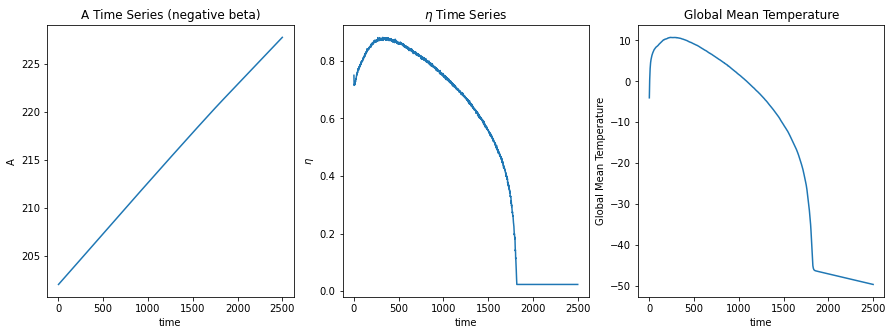

In [22]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
T_vals = budyko_modified_negative.solution[:-2,:]
T_mean = np.mean(T_vals, axis=0)
ax[0].plot(t,budyko_modified_negative.solution[-1],label="A Time Series")
ax[0].set_xlabel("time")
ax[0].set_ylabel("A")
ax[0].set_title("A Time Series (negative beta)")
ax[1].plot(t,budyko_modified_negative.solution[-2], label="Eta time series")
ax[1].set_xlabel("time")
ax[1].set_ylabel("$\eta$")
ax[1].set_title("$\eta$ Time Series")
ax[2].plot(t, T_mean)
ax[2].set_xlabel("time")
ax[2].set_ylabel("Global Mean Temperature")
ax[2].set_title("Global Mean Temperature")
plt.show()

# Exponential Growth

In [23]:
def init_T(y):
    return 14-54*np.square(y)
y_vals = np.linspace(0,1,500)
#T_init with a design function (not the actual values)
T_init = init_T(y_vals)
eta_0 = 0.75

<Figure size 432x288 with 0 Axes>

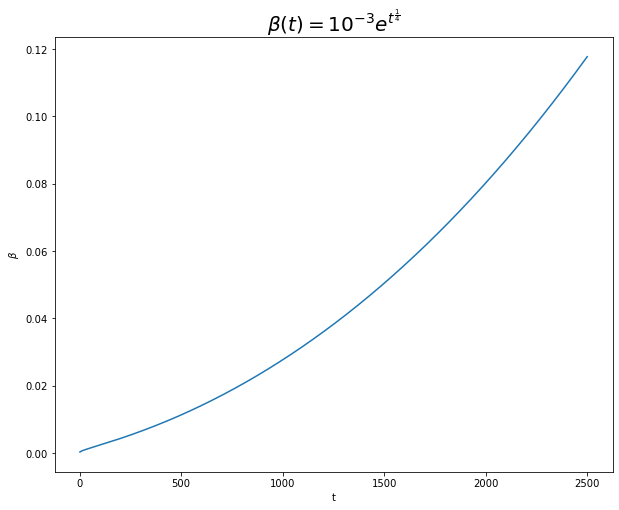

In [24]:
def beta(t_val):
    return 1e-4*np.exp(np.power(t_val,1/4))
#now use the model
#time values
t = np.linspace(1,2500,2500,endpoint = True, dtype=int)
budyko_modified_exponential = ModifiedBudykoSellers(T_init, y_vals, beta, beta_0=0.01, eta_0=eta_0)
budyko_modified_exponential.get_solution(t)
plt.clf()
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(t, beta(t))
ax.set_title(r"$\beta(t)=10^{-3}e^{t^{\frac{1}{4}}}$")
ax.title.set_fontsize(20)
ax.set_xlabel("t")
ax.set_ylabel(r"$\beta$")
plt.show()

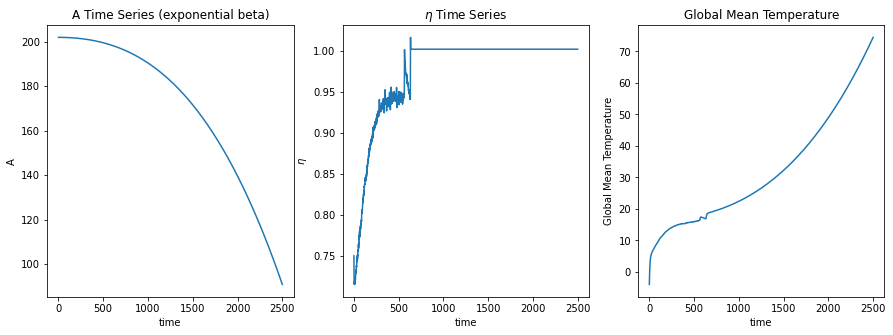

In [25]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
T_vals = budyko_modified_exponential.solution[:-2,:]
T_mean = np.mean(T_vals, axis=0)
ax[0].plot(t,budyko_modified_exponential.solution[-1],label="A Time Series")
ax[0].set_xlabel("time")
ax[0].set_ylabel("A")
ax[0].set_title("A Time Series (exponential beta)")
ax[1].plot(t,budyko_modified_exponential.solution[-2], label="Eta time series")
ax[1].set_xlabel("time")
ax[1].set_ylabel("$\eta$")
ax[1].set_title("$\eta$ Time Series")
ax[2].plot(t, T_mean)
ax[2].set_xlabel("time")
ax[2].set_ylabel("Global Mean Temperature")
ax[2].set_title("Global Mean Temperature")
plt.show()

# Exponential Decrease

In [26]:
def init_T(y):
    return 14-54*np.square(y)
y_vals = np.linspace(0,1,500)
#T_init with a design function (not the actual values)
T_init = init_T(y_vals)
eta_0 = 0.75

<Figure size 432x288 with 0 Axes>

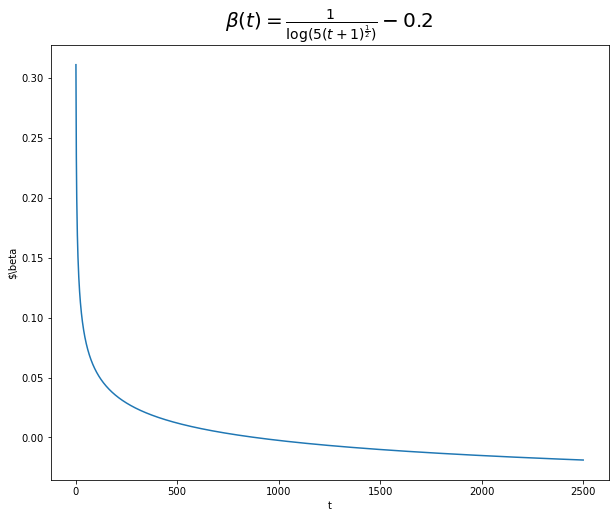

In [27]:
def beta(t_val):
    return 1/np.log(5*np.power(t_val+1,1/2)) - 0.20
#now use the model
#time values
t = np.linspace(1,2500,2500,endpoint = True, dtype=int)
budyko_modified_exp_dec = ModifiedBudykoSellers(T_init, y_vals, beta, beta_0=0.01, eta_0=eta_0)
budyko_modified_exp_dec.get_solution(t)
plt.clf()
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(t, beta(t))
ax.set_ylabel(r"$\beta")
ax.set_xlabel("t")
ax.set_title(r"$\beta(t)=\frac{1}{\log(5(t+1)^{\frac{1}{2}})}-0.2$")
ax.title.set_fontsize(20)
plt.show()

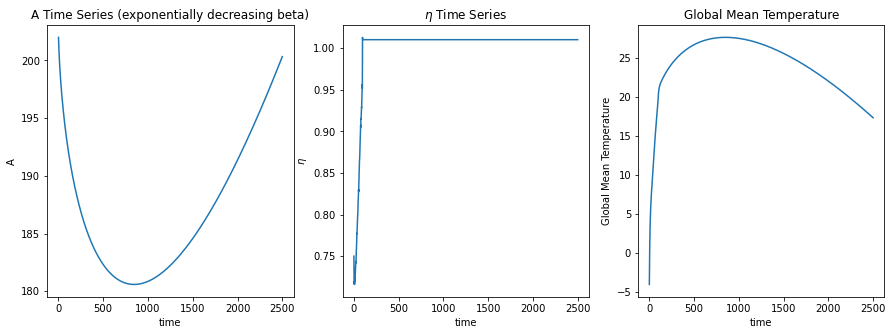

In [28]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
T_vals = budyko_modified_exp_dec.solution[:-2,:]
T_mean = np.mean(T_vals, axis=0)
ax[0].plot(t,budyko_modified_exp_dec.solution[-1],label="A Time Series")
ax[0].set_xlabel("time")
ax[0].set_ylabel("A")
ax[0].set_title("A Time Series (exponentially decreasing beta)")
ax[1].plot(t,budyko_modified_exp_dec.solution[-2], label="Eta time series")
ax[1].set_xlabel("time")
ax[1].set_ylabel("$\eta$")
ax[1].set_title("$\eta$ Time Series")
ax[2].plot(t, T_mean)
ax[2].set_xlabel("time")
ax[2].set_ylabel("Global Mean Temperature")
ax[2].set_title("Global Mean Temperature")
plt.show()